In [1]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar
from datetime import date
import yaml
import io
import json
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

%matplotlib inline

/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1685: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                nb_profiles=nb_profiles+len(indz[0])
        return nb_profiles


In [3]:
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb_profiles_NATL60_1year=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb_profiles_NATL60_1year


90549.0


In [4]:
#quadrillage tous les 0.5°

Xbox=(lonmax-lonmin+1)/0.5
Ybox=(latmax-latmin+1)/0.5

nb_prof_box05_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+0.5*j
        lat2=latmin+0.5*(j+1.)
        lon1=lonmin+0.5*i
        lon2=lonmin+0.5*(i+1.)
        nb=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
        nb_prof_box05_1year[i,j,0]=nb
        nb_prof_box05_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box05_1year[i,j,2]=0.5*(lon1+lon2)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [6]:
nb_prof_box05_1year.shape

(178, 68, 3)

In [7]:
np.nanmax(nb_prof_box05_1year[:,:,0])

4538.0

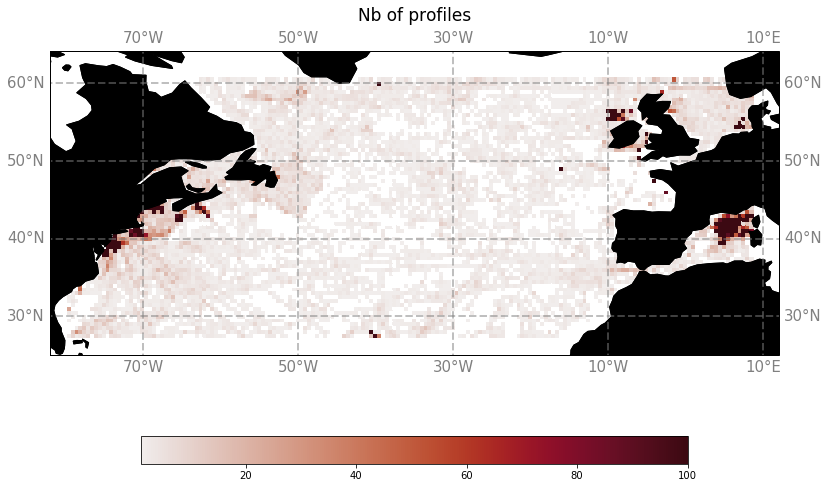

In [8]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1],nb_prof_box05_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=100)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage025.png")

In [25]:
id100=np.where(nb_prof_box05_1year[:,:,0]>100)
id100[0].shape

In [28]:
nb_prof_box05_1year[idgrand[0][:],idgrand[1][:],0]

array([ 1501.,  1188.,   424.,  1360.,  1043.,   353.,  1452.,   464.,
         263.,   381.,   563.,   658.,   249.,   219.,   333.,   246.,
         275.,   233.,  4192.,   215.,  4294.,   240.,  4206.,  4538.,
        2942.,  4255.,   236.,   900.,   631.,   345.,  2171.,  1931.,
         388.,   218.,   632.,   430.,   268.,   277.,   324.,   274.,
         519.,   461.,   206.,   231.,   285.,   578.,   320.,   377.,
         365.,   673.,   421.,   229.,   305.,   364.,   226.,   242.,
         286.,   527.,   278.,   546.,   251.,   257.,   683.,   419.,
         370.,   302.,   902.,   220.])

In [18]:
id101=np.where(nb_prof_box05_1year[:,:,0]==101)

In [20]:
print id101[0][0], id101[1][0]

152 58


In [21]:
nb_prof_box05_1year[152,58,0]

101.0

In [22]:
nb_prof_box05_1year[152,58,1]

56.25

In [23]:
nb_prof_box05_1year[152,58,2]

-3.75

In [24]:
latmin,latmax,lonmin,lonmax = 56,56.5,-4,-3.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb101=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb101


101.0


In [29]:
id206=np.where(nb_prof_box05_1year[:,:,0]==206)
print id206[0][0], id206[1][0]
print "nb", nb_prof_box05_1year[id206[0][0], id206[1][0],0]
print "lat", nb_prof_box05_1year[id206[0][0], id206[1][0],1]
print "lon", nb_prof_box05_1year[id206[0][0], id206[1][0],2]

169 25
nb 206.0
lat 39.75
lon 4.75


In [31]:
latmin,latmax,lonmin,lonmax = 39.5,40,4.5,5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb206=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb206



206.0


In [32]:
idgrand=np.where(nb_prof_box05_1year[:,:,0]>500)

In [33]:
nb_prof_box05_1year[idgrand[0][:],idgrand[1][:],0]

array([ 1501.,  1188.,  1360.,  1043.,  1452.,   563.,   658.,  4192.,
        4294.,  4206.,  4538.,  2942.,  4255.,   900.,   631.,  2171.,
        1931.,   632.,   519.,   578.,   673.,   527.,   546.,   683.,
         902.])

In [34]:
id519=np.where(nb_prof_box05_1year[:,:,0]==519)
print id519[0][0], id519[1][0]
print "nb", nb_prof_box05_1year[id519[0][0], id519[1][0],0]
print "lat", nb_prof_box05_1year[id519[0][0], id519[1][0],1]
print "lon", nb_prof_box05_1year[id519[0][0], id519[1][0],2]

168 28
nb 519.0
lat 41.25
lon 4.25


In [35]:
latmin,latmax,lonmin,lonmax = 41,41.5,4,4.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb519=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb519


519.0


In [36]:
id1043=np.where(nb_prof_box05_1year[:,:,0]==1043)
print id1043[0][0], id1043[1][0]
print "nb", nb_prof_box05_1year[id1043[0][0], id1043[1][0],0]
print "lat", nb_prof_box05_1year[id1043[0][0], id1043[1][0],1]
print "lon", nb_prof_box05_1year[id1043[0][0], id1043[1][0],2]

10 23
nb 1043.0
lat 38.75
lon -74.75


In [37]:
latmin,latmax,lonmin,lonmax = 38.5,39,-75,-74.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb1043=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb1043

1043.0


In [38]:
idmax=np.where(nb_prof_box05_1year[:,:,0]==np.nanmax(nb_prof_box05_1year[:,:,0]))

In [39]:
print idmax[0][0], idmax[1][0]
print "nb", nb_prof_box05_1year[idmax[0][0], idmax[1][0],0]
print "lat", nb_prof_box05_1year[idmax[0][0], idmax[1][0],1]
print "lon", nb_prof_box05_1year[idmax[0][0], idmax[1][0],2]

23 34
nb 4538.0
lat 44.25
lon -68.25


In [40]:
latmin,latmax,lonmin,lonmax = 44,44.5,-68.5,-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax

4538.0


In [41]:
nb_prof_box05_1year.shape

(178, 68, 3)

In [42]:
idnonzeros=np.where(nb_prof_box05_1year[:,:,0]>0)

In [43]:
idnonzeros[0].shape

(6401,)

In [44]:
idmille=np.where(nb_prof_box05_1year[:,:,0]>1000)

In [45]:
idmille[0].shape

(13,)

In [46]:
idcent=np.where(nb_prof_box05_1year[:,:,0]>100)
idcent[0].shape

(102,)